In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from geopy.distance import great_circle
import time
from shapely.geometry import MultiPoint
%matplotlib inline

In [2]:
df = pd.read_csv('CrimeDowntown2019.csv')
dfs_18 = [pd.read_csv('CrimeDowntown2018_jan_apr.csv'), pd.read_csv('CrimeDowntown2018_may_aug.csv'), pd.read_csv('CrimeDowntown2018_sept_dec.csv')]

In [3]:
df.head()

,date,primary_type,x_coordinate,y_coordinate,latitude,longitude
0,2019-04-15 23:25:00 UTC,ASSAULT,1175207.0,1908349.0,41.903892,-87.631858
1,2019-04-15 21:40:00 UTC,DECEPTIVE PRACTICE,1176389.0,1900278.0,41.881718,-87.627760
2,2019-04-15 21:10:00 UTC,CRIMINAL DAMAGE,1177417.0,1895669.0,41.869048,-87.624126
3,2019-04-15 20:00:00 UTC,CRIMINAL DAMAGE,1174938.0,1907711.0,41.902148,-87.632866
4,2019-04-15 20:00:00 UTC,THEFT,1176278.0,1903807.0,41.891405,-87.628062


In [4]:
df.primary_type.unique()

array(['ASSAULT', 'DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'THEFT',
       'MOTOR VEHICLE THEFT', 'BATTERY', 'CRIMINAL TRESPASS',
       'PUBLIC PEACE VIOLATION', 'OTHER OFFENSE', 'ROBBERY',
       'WEAPONS VIOLATION', 'CRIM SEXUAL ASSAULT', 'BURGLARY', 'NARCOTICS',
       'SEX OFFENSE', 'INTIMIDATION', 'INTERFERENCE WITH PUBLIC OFFICER',
       'LIQUOR LAW VIOLATION', 'OFFENSE INVOLVING CHILDREN', 'HOMICIDE',
       'OBSCENITY', 'STALKING', 'PROSTITUTION', 'KIDNAPPING', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION'], dtype=object)

In [5]:
#concatenate 2018 dataframes
df_18 = pd.concat(dfs_18)

In [197]:
# df_thefts = df[df.primary_type == 'ASSAULT']
df_18_thefts = df_18[df_18.primary_type == 'CONCEALED CARRY LICENSE VIOLATION']
df_18_thefts.sort_values('date', inplace=True)
df_18_thefts.head()

C:\Users\ailin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,primary_type,x_coordinate,y_coordinate,latitude,longitude
5937,2018-02-18 04:38:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1178046.0,1905133.0,41.895003,-87.621528
7756,2018-06-16 00:59:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1177005.0,1893206.0,41.862299,-87.625713
1149,2018-08-19 15:51:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1173303.0,1895451.0,41.868542,-87.639235
3995,2018-11-15 03:30:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1179215.0,1898967.0,41.878057,-87.617424


In [198]:
#df_thefts.dropna(inplace=True)
df_18_thefts.dropna(inplace=True)
df_18_thefts.head()

C:\Users\ailin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,primary_type,x_coordinate,y_coordinate,latitude,longitude
5937,2018-02-18 04:38:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1178046.0,1905133.0,41.895003,-87.621528
7756,2018-06-16 00:59:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1177005.0,1893206.0,41.862299,-87.625713
1149,2018-08-19 15:51:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1173303.0,1895451.0,41.868542,-87.639235
3995,2018-11-15 03:30:00 UTC,CONCEALED CARRY LICENSE VIOLATION,1179215.0,1898967.0,41.878057,-87.617424


In [199]:
print ("Number of thefts: ", df_18_thefts.shape[0])
print ("Number of thefts: ", df_18.shape[0])

Number of thefts:  4
Number of thefts:  32611


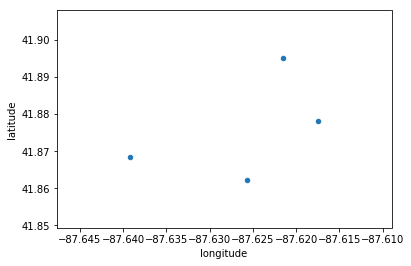

In [200]:
df_18_thefts.plot.scatter(x='longitude', y='latitude')

In [169]:
df_samp = df_18_thefts.sample(frac=0.10)

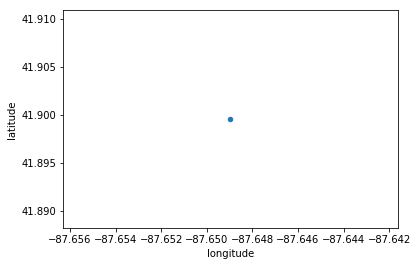

In [170]:
df_samp.plot.scatter(x='longitude', y='latitude')

## Train DBSCAN

In [171]:
numpy_matrix_samp = df_samp.as_matrix(columns=['latitude', 'longitude'])
numpy_matrix = df_18_thefts.as_matrix(columns=['latitude', 'longitude'])
numpy_matrix.shape

(11, 2)

In [172]:
numpy_matrix

array([[ 41.88194442, -87.63419529],
       [ 41.89482493, -87.63178864],
       [ 41.86522509, -87.65734107],
       [ 41.88738476, -87.62455074],
       [ 41.85841276, -87.62394571],
       [ 41.87649384, -87.62604438],
       [ 41.86612915, -87.65754448],
       [ 41.89954984, -87.64896057],
       [ 41.89670179, -87.62638709],
       [ 41.90440853, -87.63145965],
       [ 41.85519055, -87.6238712 ]])

In [173]:
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm

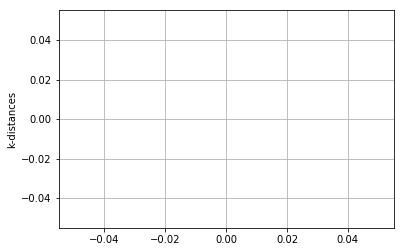

In [174]:
#convert to radians for harversine metric
m, m2= k_distances2(numpy_matrix_samp, 2) 
plt.plot(m2)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

### DBSCAN

In [181]:
#convert matrix into radians before using haversine metric
db = DBSCAN(eps=np.radians(0.01), min_samples=3, metric='haversine', algorithm="ball_tree").fit(np.radians(numpy_matrix))

In [182]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [183]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("Number of clusters: ", n_clusters_)

Number of clusters:  1


In [184]:
n_noise_ = list(labels).count(-1)
print("Number of noise points: ", n_noise_)

Number of noise points:  5


### Evaluation with Silhoette Coefficient: 

In [185]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(np.radians(numpy_matrix), labels))

Silhouette Coefficient: 0.342


In [186]:
#most frequent label
u, indices = np.unique(labels, return_inverse=True)
print("Most frequent class label: ", u[np.argmax(np.bincount(indices))])

Most frequent class label:  0


In [187]:
X = numpy_matrix

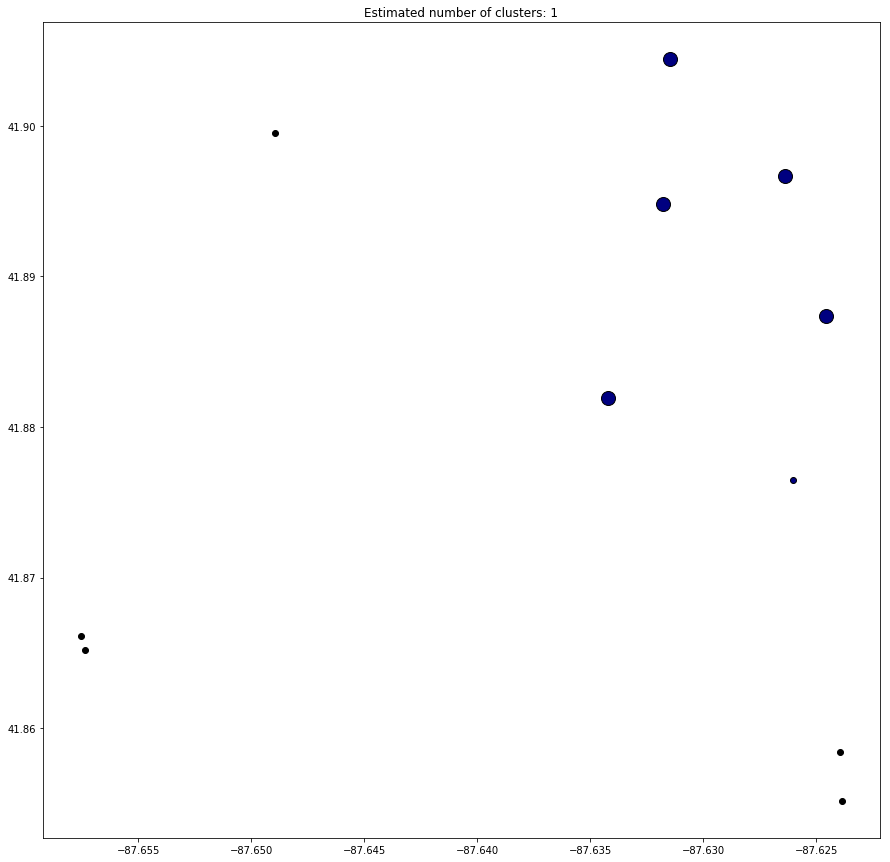

In [188]:
# Black removed and is used for noise instead.
plt.figure(figsize=(15,15))
unique_labels = set(labels)
colors = [plt.cm.gist_ncar(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [189]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([numpy_matrix[labels==n] for n in range(n_clusters_)])

In [190]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)


In [191]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lat,lon
0,41.887385,-87.624551


In [192]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df_18_thefts[(df_18_thefts['latitude']==row['lat']) & (df_18_thefts['longitude']==row['lon'])].iloc[0], axis=1)
rs.to_csv('crimes-dbscan.csv', encoding='utf-8')
rs.tail()

,date,primary_type,x_coordinate,y_coordinate,latitude,longitude
0,2018-07-10 00:08:00 UTC,ARSON,1177246.0,1902350.0,41.887385,-87.624551


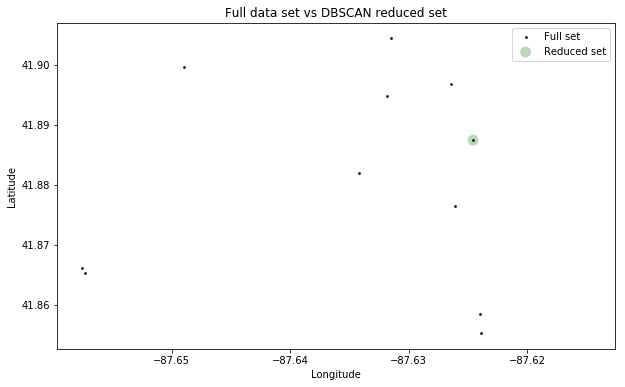

In [193]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['longitude'], rs['latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df_18_thefts['longitude'], df_18_thefts['latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

## Folium Visualization

In [194]:
import folium
from folium import plugins
import seaborn as sns

m = folium.Map(location=[41.879194,-87.6564163], tiles='Stamen Toner', zoom_start=13)

In [195]:
# # mark each theft as a point
# for index, row in rep_points.iterrows():
#     folium.CircleMarker([row['lat'], row['lon']],
#                         radius=5,
#                         fill_color="#3db7e4", # divvy color
#                        ).add_to(m)

In [196]:
# convert to (n, 2) nd-array format for heatmap
rep_pointsArr = rep_points[['lat', 'lon']].as_matrix()

# plot heatmap
m.add_child(plugins.HeatMap(rep_pointsArr.tolist(), radius=20))
m